<a href="https://colab.research.google.com/github/Jipsonmv/Bagging-Boosting-Project/blob/main/Bagging_Boosting_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Understanding the Business Problem
TalkingData is a Chinese big data company, and one of their areas of expertise is mobile advertisements.

In mobile advertisements, click fraud is a major source of losses. Click fraud is the practice of repeatedly clicking on an advertisement hosted on a website with the intention of generating revenue for the host website or draining revenue from the advertiser.

In this case, TalkingData happens to be serving the advertisers (their clients). TalkingData cover a whopping approx. 70% of the active mobile devices in China, of which 90% are potentially fraudulent (i.e. the user is actually not going to download the app after clicking).

You can imagine the amount of money they can help clients save if they are able to predict whether a given click is fraudulent (or equivalently, whether a given click will result in a download).

Their current approach to solve this problem is that they've generated a blacklist of IP addresses - those IPs which produce lots of clicks, but never install any apps. Now, they want to try some advanced techniques to predict the probability of a click being genuine/fraud.

In this problem, we will use the features associated with clicks, such as IP address, operating system, device type, time of click etc. to predict the probability of a click being fraud.

#Project on Bagging and Boosting ensemble model:
The data contains observations of about 240 million clicks, and whether a given click resulted in a download or not (1/0):

The detailed data dictionary is mentioned here:

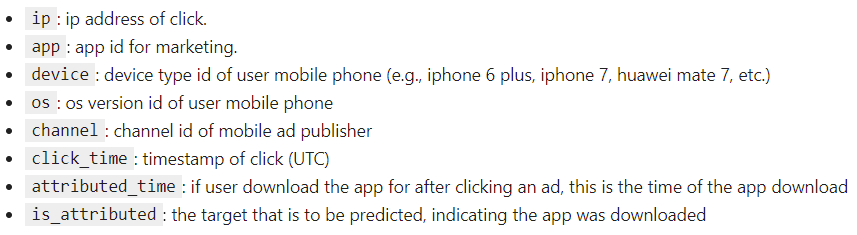

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import zscore

1) Explore the dataset for anomalies and missing values and take corrective actions if necessary

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Tech I.S/csv files/talking_data.csv")
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [3]:
df.shape

(100000, 8)

Checking the presence of missing values

In [4]:
df.isnull().values.any()

True

In [5]:
df.isnull().sum()

ip                     0
app                    0
device                 0
os                     0
channel                0
click_time             0
attributed_time    99773
is_attributed          0
dtype: int64

Since majority of the attributed_time column are null values, dropping the entire column.

In [6]:
df = df.drop(['attributed_time'],axis = 1)

In [7]:
df

,ip,app,device,os,channel,click_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,0
1,105560,25,1,17,259,2017-11-07 13:40:27,0
2,101424,12,1,19,212,2017-11-07 18:05:24,0
3,94584,13,1,13,477,2017-11-07 04:58:08,0
4,68413,12,1,1,178,2017-11-09 09:00:09,0
...,...,...,...,...,...,...,...
99995,124883,11,1,19,122,2017-11-09 13:25:41,0
99996,85150,9,1,13,244,2017-11-07 11:25:43,0
99997,18839,3,1,13,19,2017-11-08 11:38:42,0
99998,114276,15,1,12,245,2017-11-08 17:55:21,0


In [8]:
df.isnull().sum()

ip               0
app              0
device           0
os               0
channel          0
click_time       0
is_attributed    0
dtype: int64

In [9]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ip             100000 non-null  int64 
 1   app            100000 non-null  int64 
 2   device         100000 non-null  int64 
 3   os             100000 non-null  int64 
 4   channel        100000 non-null  int64 
 5   click_time     100000 non-null  object
 6   is_attributed  100000 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 5.3+ MB
None
                  ip           app         device             os  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean    91255.879670      12.04788      21.771250      22.818280   
std     69835.553661      14.94150     259.667767      55.943136   
min         9.000000       1.00000       0.000000       0.000000   
25%     40552.000000       3.00000       1.000000      13.000000   
50%     79827.000000      12.000

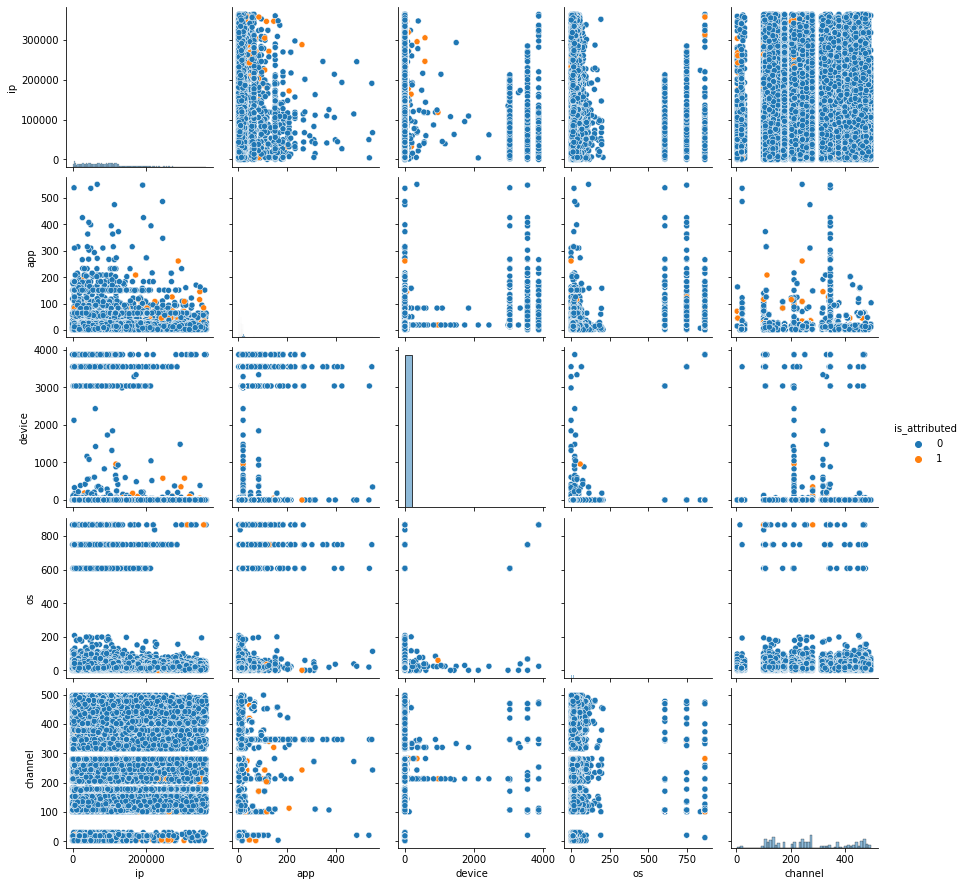

In [10]:
sns.pairplot(df, hue = 'is_attributed', diag_kind = 'hist')

In [11]:
corr = df.corr()
corr

,ip,app,device,os,channel,is_attributed
ip,1.000000,0.010400,-0.001499,-0.000470,0.007563,0.054955
app,0.010400,1.000000,0.248376,0.247160,-0.028238,0.064426
device,-0.001499,0.248376,1.000000,0.924456,-0.035398,-0.000695
os,-0.000470,0.247160,0.924456,1.000000,-0.033175,0.006183
channel,0.007563,-0.028238,-0.035398,-0.033175,1.000000,-0.023336
is_attributed,0.054955,0.064426,-0.000695,0.006183,-0.023336,1.000000


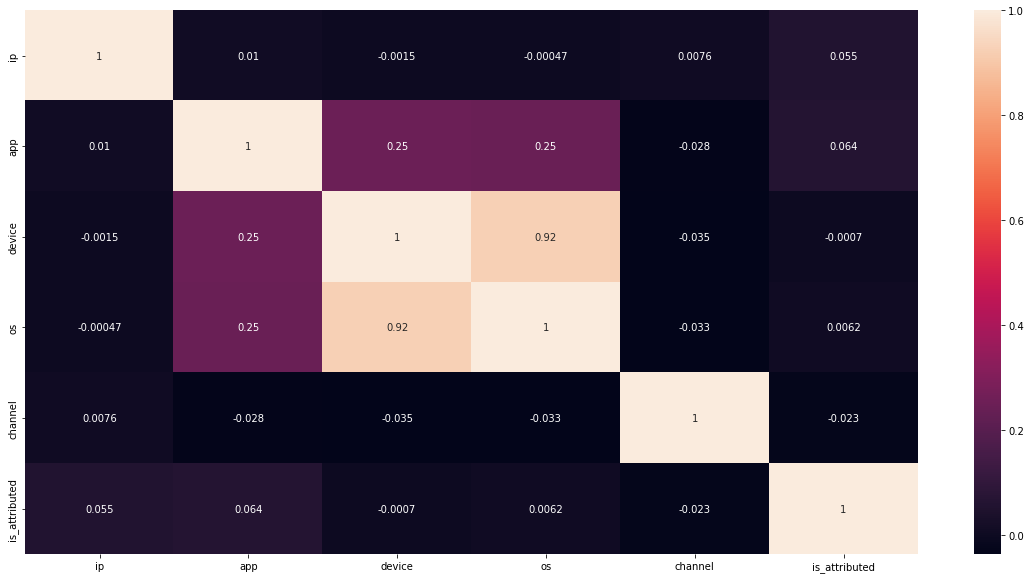

In [12]:
plt.figure(figsize = (20,10))
sns.heatmap(corr, annot = True)

In [13]:
df.dtypes

ip                int64
app               int64
device            int64
os                int64
channel           int64
click_time       object
is_attributed     int64
dtype: object

2. Which column has maximum number of unique values present among all the available columns?

In [14]:
df.nunique()

ip               34857
app                161
device             100
os                 130
channel            161
click_time       80350
is_attributed        2
dtype: int64

3. Use an appropriate technique to get rid of all the apps that are very rare (say which comprise of less  than 20% clicks) and plot the rest

In [15]:
total_clicks = df.shape[0]
tw_per = (total_clicks * 0.2)


for index, value in df['app'].value_counts().items():
  if value >= tw_per:
    print("App with {} ID  has {} clicks".format(index,value))
  
# No apps are contributing more than 20% of the total clicks. 

4. By using Pandas derive new features such as - 'day_of_week' , 'day_of_year' , 'month' , and 'hour' as float/int datatypes using the 'click_time' column . Add the newly derived columns in original dataset.

In [16]:
df.click_time.dtype
import datetime

df['click_time'] = pd.to_datetime(df['click_time'])
df['day_of_week'] = df['click_time'].apply(lambda x:x.strftime('%u')).astype(int)
df['day_of_year'] = df['click_time'].apply(lambda x: x.strftime('%j')).astype(int)
df['month'] = df['click_time'].apply(lambda x: x.strftime('%m')).astype(int)
df['hour'] = df['click_time'].apply(lambda x: x.strftime('%H')).astype(int)

In [17]:
df

,ip,app,device,os,channel,click_time,is_attributed,day_of_week,day_of_year,month,hour
0,87540,12,1,13,497,2017-11-07 09:30:38,0,2,311,11,9
1,105560,25,1,17,259,2017-11-07 13:40:27,0,2,311,11,13
2,101424,12,1,19,212,2017-11-07 18:05:24,0,2,311,11,18
3,94584,13,1,13,477,2017-11-07 04:58:08,0,2,311,11,4
4,68413,12,1,1,178,2017-11-09 09:00:09,0,4,313,11,9
...,...,...,...,...,...,...,...,...,...,...,...
99995,124883,11,1,19,122,2017-11-09 13:25:41,0,4,313,11,13
99996,85150,9,1,13,244,2017-11-07 11:25:43,0,2,311,11,11
99997,18839,3,1,13,19,2017-11-08 11:38:42,0,3,312,11,11
99998,114276,15,1,12,245,2017-11-08 17:55:21,0,3,312,11,17


5. Divide the data into training and testing subsets into 80:20 ratio(Train_data = 80% , Testing_data = 20%) and
     check the average download rates('is_attributed') for train and test data, scores should be comparable.

In [18]:
from sklearn.model_selection import train_test_split    #importing Sklearn packages's data splitting function
from sklearn import metrics
from sklearn import preprocessing

x = df.drop(["is_attributed","click_time"], axis = 1)
y = df['is_attributed']

y.value_counts()


0    99773
1      227
Name: is_attributed, dtype: int64

Target values are not balanced, so running SMOTE

In [19]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
x,y = sm.fit_resample(x,y)

y.value_counts()



0    99773
1    99773
Name: is_attributed, dtype: int64

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state = 10)

6. Apply XGBoostClassifier with default parameters on training data and make first 10 prediction for Test data.          NOTE: Use y_pred = model.predict_proba(X_test) since we need probabilities to compute AUC

In [21]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

xgb_cl = xgb.XGBClassifier()

xgb_cl.fit(x_train, y_train)
y_pred = xgb_cl.predict(x_test)

xgb_score = accuracy_score(y_test, y_pred)
print(metrics.confusion_matrix(y_test,y_pred))
print("Accuracy of model is :- ",accuracy_score(y_test,y_pred))


[[19114   787]
 [ 1044 18965]]
Accuracy of model is :-  0.9541217739914808


In [22]:
y_pred[0:11]

array([0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0])

7. On evaluating the predictions made by the model what is the AUC/ROC score with default hyperparameters.

In [23]:
from sklearn.metrics import roc_auc_score

print("AUC/ROC score is :",roc_auc_score(y_test,y_pred))

AUC/ROC score is : 0.9541388639822396


8. Compute feature importance score and name the top 5 features/columns

9. Apply BaggingClassifier with base_estimator LogisticRegression and compute AUC/ROC score.

In [24]:
from sklearn.ensemble import BaggingClassifier

bgcl = BaggingClassifier(n_estimators = 10, max_samples = .8, bootstrap = True)
bgcl = bgcl.fit(x_train, y_train)
test_pred = bgcl.predict(x_test)
bgcl_score = bgcl.score(x_test, y_test)
print("The Bagging classifier model accuracy is {}".format(bgcl_score))
print("The confusion matrix of Bagging classifier model is")
print(metrics.confusion_matrix(y_test, test_pred))

The Bagging classifier model accuracy is 0.9971185166624906
The confusion matrix of Bagging classifier model is
[[19818    83]
 [   32 19977]]


In [25]:
print("AUC/ROC score is :",roc_auc_score(y_test,test_pred))

AUC/ROC score is : 0.9971150374924622


10.  On the basis of AUC/ROC score which one will you choose from BaggingClassifier and XGBoostClassifier and              why?What does AUC/ROC score signifies?

I would use BaggingClassifier as it gave highest score. 

11.  What is the accuracy for BaggingClassifier and XGBoostClassifier?

In [26]:
print("The Bagging classifier model accuracy is {}".format(bgcl_score))
print("The XGBoost classifier model accuracy is {}".format(xgb_score))

The Bagging classifier model accuracy is 0.9971185166624906
The XGBoost classifier model accuracy is 0.9541217739914808
